In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

# 从源文件加载数据，并输出查看数据的各项特征
lines = np.loadtxt('USA_Housing.csv', delimiter=',', dtype='str')
header = lines[0]
lines = lines[1:].astype(float)
print('数据特征：', ', '.join(header[:-1]))
print('数据标签：', header[-1])
print('数据总条数：', len(lines))

# 划分训练集与测试集
ratio = 0.8
split = int(len(lines) * ratio)
np.random.seed(0)
lines = np.random.permutation(lines)
train, test = lines[:split], lines[split:]

# 数据归一化
scaler = StandardScaler()
scaler.fit(train) # 只使用训练集的数据计算均值和方差
train = scaler.transform(train)
test = scaler.transform(test)

# 划分输入和标签
x_train, y_train = train[:, :-1], train[:, -1].flatten()
x_test, y_test = test[:, :-1], test[:, -1].flatten()

数据特征： Avg. Area Income, Avg. Area House Age, Avg. Area Number of Rooms, Avg. Area Number of Bedrooms, Area Population
数据标签： Price
数据总条数： 5000


In [2]:
# 在X矩阵最后添加一列1，代表常数项
X = np.concatenate([x_train, np.ones((len(x_train), 1))], axis=-1)
# @ 表示矩阵相乘，X.T表示矩阵X的转置，np.linalg.inv函数可以计算矩阵的逆
theta = np.linalg.inv(X.T @ X) @ X.T @ y_train
print('回归系数：', theta)

# 在测试集上使用回归系数进行预测
X_test = np.concatenate([x_test, np.ones((len(x_test), 1))], axis=-1)
y_pred = X_test @ theta

# 计算预测值和真实值之间的RMSE
rmse_loss = np.sqrt(np.square(y_test - y_pred).mean())
print('RMSE：', rmse_loss)

回归系数： [ 6.50881254e-01  4.67222833e-01  3.38466198e-01  6.17275856e-03
  4.26857089e-01 -1.46033359e-14]
RMSE： 0.28791834247503534


In [3]:
from sklearn.linear_model import LinearRegression

# 初始化线性模型
linreg = LinearRegression()
# LinearRegression的方法中已经考虑了线性回归的常数项，所以无须再拼接1
linreg.fit(x_train, y_train)

# coef_是训练得到的回归系数，intercept_是常数项
print('回归系数：', linreg.coef_, linreg.intercept_)
y_pred = linreg.predict(x_test)

# 计算预测值和真实值之间的RMSE
rmse_loss = np.sqrt(np.square(y_test - y_pred).mean())
print('RMSE：', rmse_loss)

回归系数： [0.65088125 0.46722283 0.3384662  0.00617276 0.42685709] -1.4635041882766192e-14
RMSE： 0.2879183424750354


In [4]:
# 该函数每次返回大小为batch_size的批量
# x和y分别为输入和标签
# 若shuffle = True，则每次遍历时会将数据重新随机划分
def batch_generator(x, y, batch_size, shuffle=True):
    # 批量计数器
    batch_count = 0
    if shuffle:
        # 随机生成0到len(x)-1的下标
        idx = np.random.permutation(len(x))
        x = x[idx]
        y = y[idx]
    while True:
        start = batch_count * batch_size
        end = min(start + batch_size, len(x))
        if start >= end:
            # 已经遍历一遍，结束生成
            break
        batch_count += 1
        yield x[start: end], y[start: end]

回归系数： [ 0.65357756  0.46682964  0.33885411  0.00720843  0.42751035 -0.00273407]


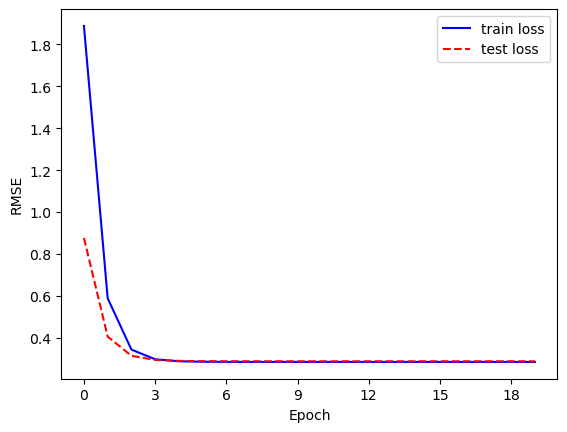

In [5]:
def SGD(num_epoch, learning_rate, batch_size):
    # 拼接原始矩阵
    X = np.concatenate([x_train, np.ones((len(x_train), 1))], axis=-1)
    X_test = np.concatenate([x_test, np.ones((len(x_test), 1))], axis=-1)
    # 随机初始化参数
    theta = np.random.normal(size=X.shape[1])

    # 随机梯度下降
    # 为了观察迭代过程，我们记录每一次迭代后在训练集和测试集上的均方根误差
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        # 初始化批量生成器
        batch_g = batch_generator(X, y_train, batch_size, shuffle=True)
        train_loss = 0
        for x_batch, y_batch in batch_g:
            # 计算梯度
            grad = x_batch.T @ (x_batch @ theta - y_batch)
            # 更新参数
            theta = theta - learning_rate * grad / len(x_batch)
            # 累加平方误差
            train_loss += np.square(x_batch @ theta - y_batch).sum()
        # 计算训练和测试误差
        train_loss = np.sqrt(train_loss / len(X))
        train_losses.append(train_loss)
        test_loss = np.sqrt(np.square(X_test @ theta - y_test).mean())
        test_losses.append(test_loss)

    # 输出结果，绘制训练曲线
    print('回归系数：', theta)
    return theta, train_losses, test_losses

# 设置迭代次数，学习率与批量大小
num_epoch = 20
learning_rate = 0.01
batch_size = 32
# 设置随机种子
np.random.seed(0)

_, train_losses, test_losses = SGD(num_epoch, learning_rate, batch_size)
    
# 将损失函数关于运行次数的关系制图，可以看到损失函数先一直保持下降，之后趋于平稳
plt.plot(np.arange(num_epoch), train_losses, color='blue', 
    label='train loss')
plt.plot(np.arange(num_epoch), test_losses, color='red', 
    ls='--', label='test loss')
# 由于epoch是整数，这里把图中的横坐标也设置为整数
# 该步骤也可以省略
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

回归系数： [0.64542258 0.47047873 0.33188398 0.00325404 0.42479699 0.00237965]
回归系数： [0.59247915 0.58561574 0.26554358 0.10173112 0.49435997 0.13108641]


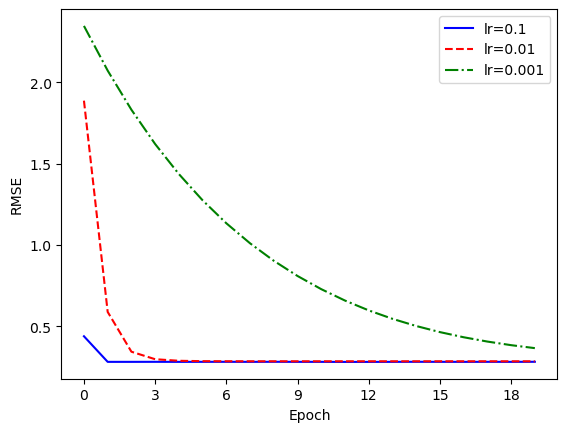

In [6]:
_, loss1, _ = SGD(num_epoch=num_epoch, learning_rate=0.1, 
    batch_size=batch_size)
_, loss2, _ = SGD(num_epoch=num_epoch, learning_rate=0.001, 
    batch_size=batch_size)
plt.plot(np.arange(num_epoch), loss1, color='blue', 
    label='lr=0.1')
plt.plot(np.arange(num_epoch), train_losses, color='red', 
    ls='--', label='lr=0.01')
plt.plot(np.arange(num_epoch), loss2, color='green',
    ls='-.', label='lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

回归系数： [ 1.02026986e+76 -1.13520942e+76  9.19402885e+75  5.66309332e+75
 -4.91083973e+75  5.35399839e+75]
最终损失： 5.336762494108163e+77


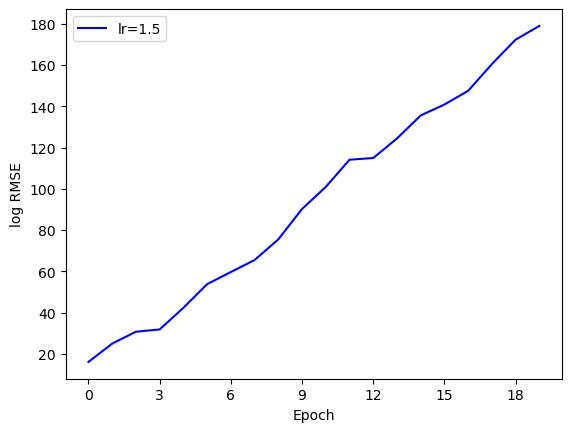

In [7]:
_, loss3, _ = SGD(num_epoch=num_epoch, learning_rate=1.5, batch_size=batch_size)
print('最终损失：', loss3[-1])
plt.plot(np.arange(num_epoch), np.log(loss3), color='blue', label='lr=1.5')
plt.xlabel('Epoch')
plt.ylabel('log RMSE')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()